# Hyperspectral Tutorial

Example analysis of a hyperspectral image. This includes white reference and dark reference normalization but please note that that sample image (corn kernel) in this case has already been normalized to the white and dark references before the original image was cropped. We are just showing these steps for the sake of the tutorial. 

Updated September 2025

# Section 1: Importing Image and Libraries

In [1]:
# Set the notebook display method
# If widget is not working, then change to inline
%matplotlib widget

# Import libraries
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs

# Print out the version of PlantCV being used by the Jupyter kernel
pcv.__version__

'4.10.dev8+g83b15e008.d20250820'

## Input/Output variables

The options class mimics the workflow command-line argument parser that is used for workflow parallelization. Using it while developing a workflow in Jupyter makes it easier to convert the workflow to a script later. Remember, always keep your raw images separate from your newly processed images!

In [2]:
# Input/output options
args = WorkflowInputs(
    images=["./img/4-22-22_right_same_B73_top_00.raw"],
    names="image1",
    result="hyperspectral_result",
    outdir=".",
    writeimg=True,
    debug="plot"
    )

In [3]:
# Set debug to the global parameter 
pcv.params.debug = args.debug
# Change display settings
pcv.params.dpi = 100
# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 0.5
pcv.params.text_thickness = 1
pcv.params.line_thickness = 1

## Read the input image

### Reading images into your environment using *pcv.readimage()*
Inputs:
   * filename = Image file to be read in
   * mode     = How the image will be read into the notebook; either 'native' (default), 'rgb', 'gray', 'csv', or 'envi'

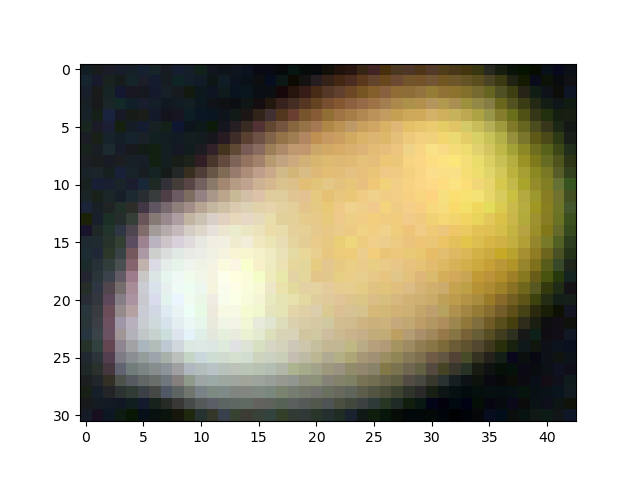

In [4]:
# read hyperspectral image. With the ENVI format the input file should be a .raw. 
#If you were using a differen format the filename should be a .hdr file that includes information for shaping data (see readimage instructions)
spectral_array = pcv.readimage(filename=args.image1, mode='envi')

### Image calibration 

Read in dark and white reference files, please note that the one of the dimensions (likely width needs to match your raw data)


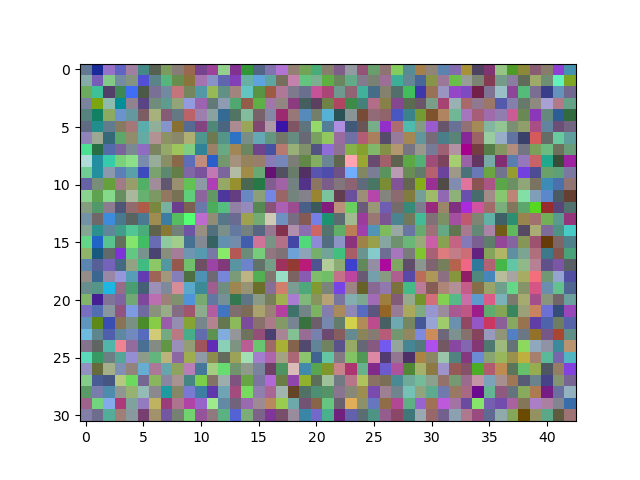

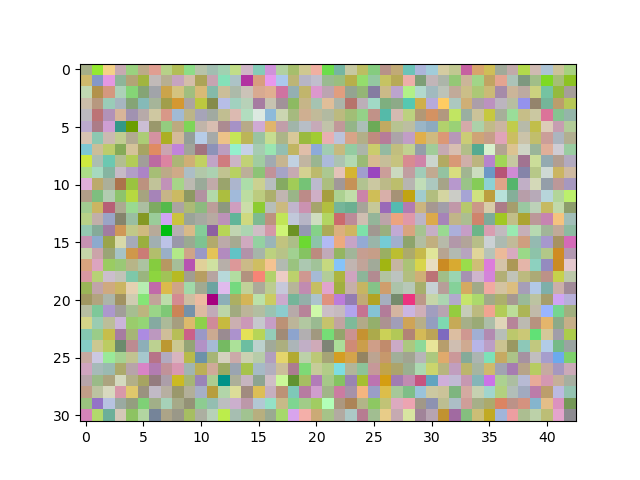

In [5]:

white_img = "./img/white_reference_crop.raw"
dark_img = "./img/dark_reference_crop.raw"

white_ref = pcv.readimage(filename= white_img, mode='envi')
dark_ref= pcv.readimage(filename= dark_img, mode='envi')

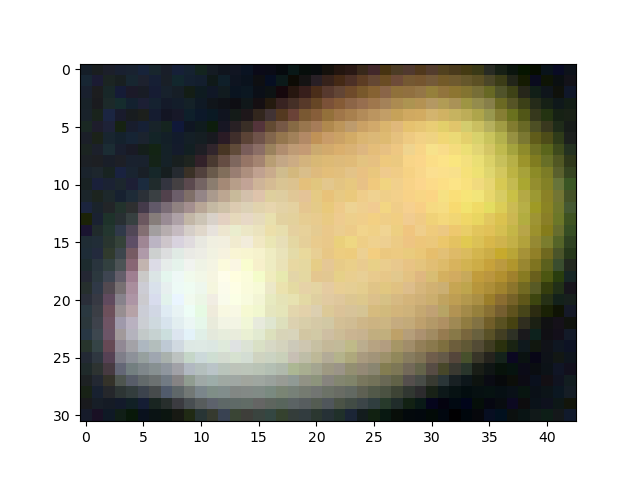

In [6]:
# Calibrate data to white and dark references

calibrated_data = pcv.hyperspectral.calibrate(raw_data=spectral_array, white_reference=white_ref, dark_reference=dark_ref)

## Segment seed 

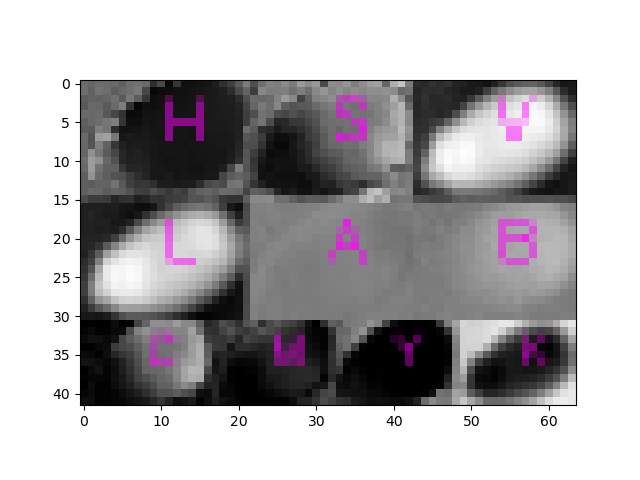

In [7]:
#Next step is to segment the target object from the background pixels
#This step is just to aid in picking a changel with good constrast between the target object and background

colorspace_img = pcv.visualize.colorspaces(rgb_img=calibrated_data.pseudo_rgb, original_img=False)

In this example the l channel from LAB colorspace looks like it has good contrast.
Alternatively instead of using the pseudo_rgb image you could calculate an index from the hyperspectral values by using the 'pcv.spectral_index' function and finding an index that has good seperation between object and background then thresholding like this pipeline does


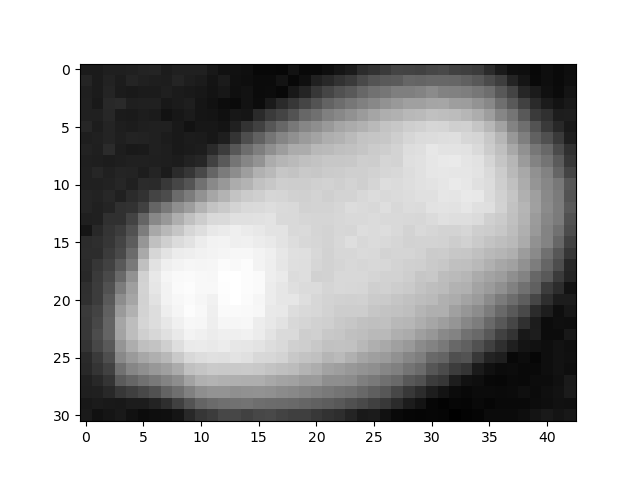

In [8]:
# Store the "l" channel to a variable
l = pcv.rgb2gray_lab(rgb_img=calibrated_data.pseudo_rgb, channel='l')

In [9]:
# plot histogram of data to more easily select a threshold. 
# Please note this step would not be included in a workflow when run in parallel

hist_figure1= pcv.visualize.histogram(l, bins=10)

alt.Chart(...)

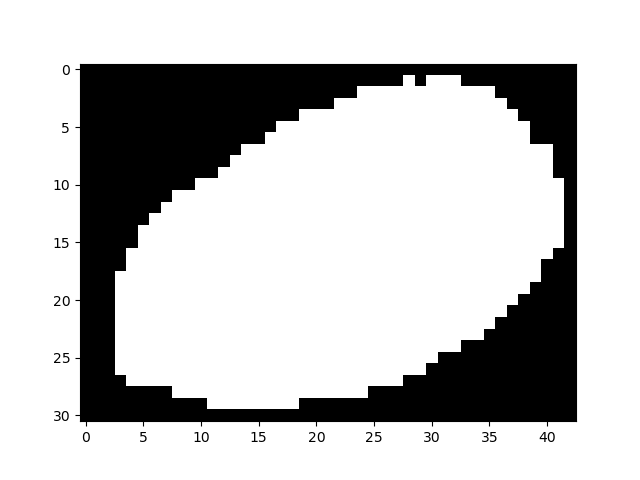

In [10]:
# Select a threshold value that isolates your target object well. If necessary do additional steps to clean up the mask.

corn_thresh = pcv.threshold.binary(gray_img=l, threshold=100)

## Spectral analysis 

In [11]:
# Look at a histogram of the hyperspectral data, if you had more than one object you would need a matrix with 
# each object labeled with a different value.

spectral_hist  = pcv.analyze.spectral_reflectance(hsi=calibrated_data, labeled_mask=corn_thresh, n_labels=1, label="kernel")

alt.FacetChart(...)

## Calculate spectral indicies

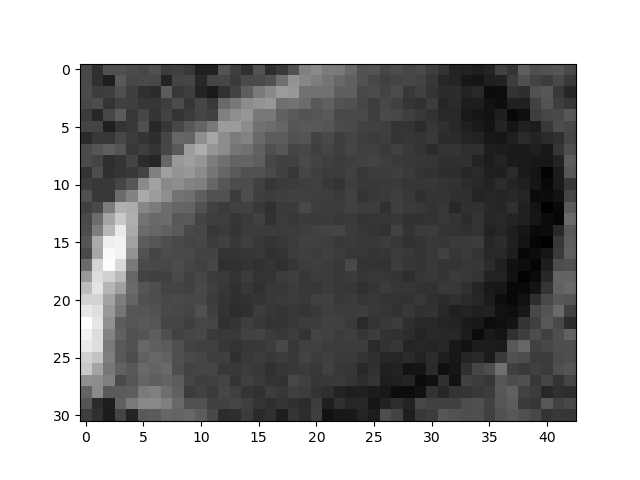

In [12]:
# Calculate an index (many are available see plantcv.spectral_index)
# Or you can calculate your own manually by using plantcv.hyperspectral.extract_wavelength
ndvi_index  = pcv.spectral_index.ndvi(hsi=calibrated_data, distance=20)

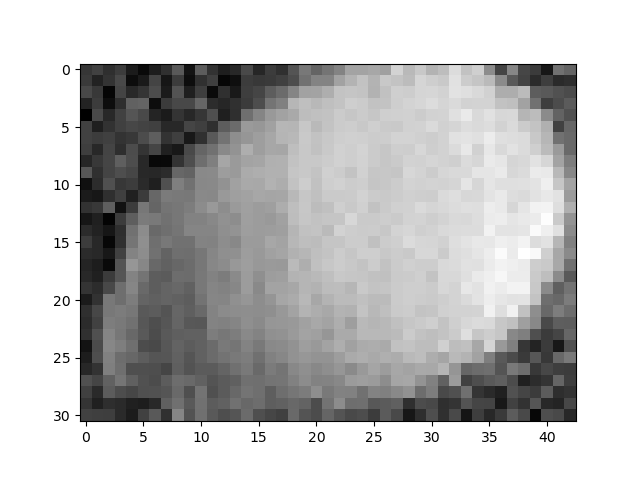

In [13]:
# Calculate the Carotenoid Index from the datacube 

index_array_car = pcv.spectral_index.psri(hsi=calibrated_data, distance=5)


In [14]:
# Graph the histogram of the spectral index

ndvi_output=pcv.analyze.spectral_index(index_img=ndvi_index, labeled_mask=corn_thresh,
                           min_bin=-1, max_bin=1, label="kernel")

alt.FacetChart(...)

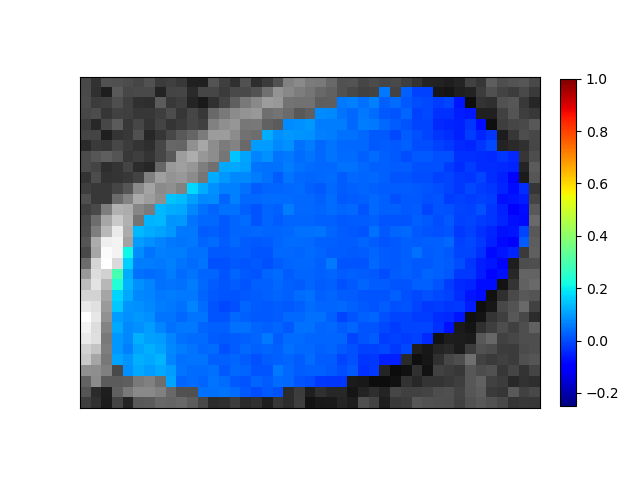

In [15]:
# pseudocolor the image as a visualization

ndvi_img = pcv.visualize.pseudocolor(gray_img = ndvi_index.array_data, mask=corn_thresh, cmap='jet', 
                                           min_value=-0.25, max_value=1)

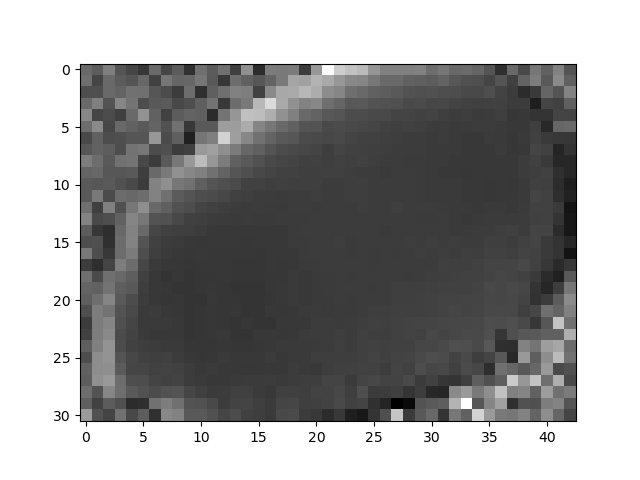

In [16]:
# Calculate an index (many are available see plantcv.spectral_index)
# Or you can calculate your own manually by using plantcv.hyperspectral.extract_wavelength
ari_index  = pcv.spectral_index.ari(hsi=calibrated_data, distance=20)

In [17]:
# Graph the histogram of the spectral index

ari_output=pcv.analyze.spectral_index(index_img=ari_index, labeled_mask=corn_thresh,
                           min_bin=-5, max_bin=5, label="kernel")

alt.FacetChart(...)

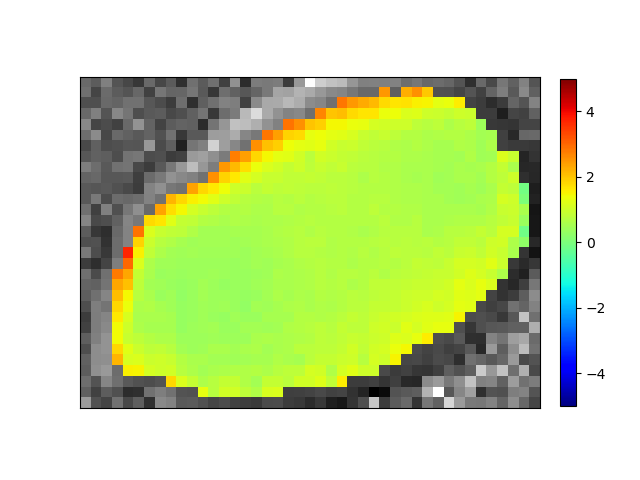

In [18]:
ari_img = pcv.visualize.pseudocolor(gray_img = ari_index.array_data, mask=corn_thresh, cmap='jet', 
                                           min_value=-5, max_value=5)

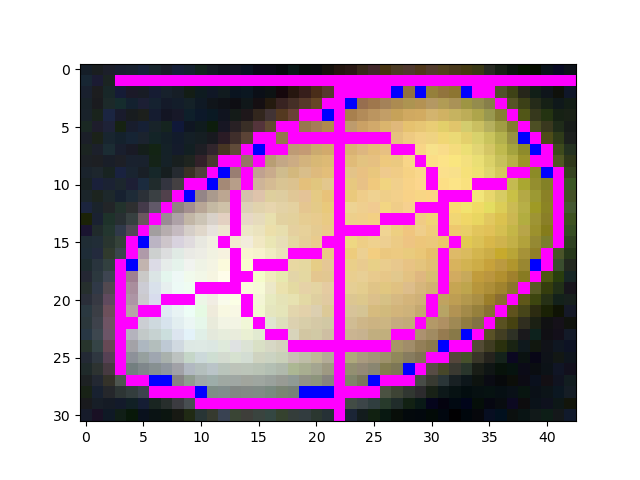

804.0


In [19]:
#Do shape analysis (the output image will look a little strange because the image is so small)

shape_image = pcv.analyze.size(img=calibrated_data.pseudo_rgb, labeled_mask=corn_thresh, n_labels=1, label="kernel")

#print out results just to see (this wouldn't be included in a workflow run in parallel)
area = pcv.outputs.observations['kernel_1']['area']['value']
print(area)

## Save the results

During `analyze` functions ([`pcv.analyze.size`](https://plantcv.readthedocs.io/en/latest/analyze_size/), [`pcv.analyze.spectral_index`](https://plantcv.readthedocs.io/en/latest/analyze_spectral_index/), and [`pcv.analyze.spectral_reflectance`](https://plantcv.readthedocs.io/en/latest/analyze_spectral_reflectance/))  measurements are stored in the background in the `outputs` class.

In [20]:
# Save out the results

pcv.outputs.save_results(filename=args.result)